<a href="https://colab.research.google.com/github/aaryamanz/Anomaly-Detection-and-Risk-Scoring-with-GARCH-Based-Volatility-in-Time-Series-Analysis-for-VFV/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [2]:
!pip install yfinance


In [57]:
import yfinance as yf
import pandas as pd

# ('VFV' for Vanguard S&P 500 Index ETF)
ticker = "VFV.TO"
data = yf.download(ticker, interval="1d", period="1y")  # Pulls 1 year of 1d-level data

data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,VFV.TO,VFV.TO,VFV.TO,VFV.TO,VFV.TO,VFV.TO
Date,,,,,,
2023-11-08 00:00:00+00:00,106.127380,107.360001,107.419998,106.839996,107.360001,134400
2023-11-09 00:00:00+00:00,105.336563,106.559998,107.599998,106.510002,107.599998,118400
2023-11-10 00:00:00+00:00,106.878662,108.120003,108.209999,107.000000,107.290001,129300
2023-11-13 00:00:00+00:00,106.848999,108.089996,108.230003,107.790001,107.970001,117200
2023-11-14 00:00:00+00:00,108.074768,109.330002,109.750000,108.989998,109.000000,204700


In [58]:
data.columns = ['_'.join(col).strip() for col in data.columns]
print(data.columns)

Index(['Adj Close_VFV.TO', 'Close_VFV.TO', 'High_VFV.TO', 'Low_VFV.TO',
       'Open_VFV.TO', 'Volume_VFV.TO'],
      dtype='object')


In [59]:

data.rename(columns={'Close_VFV.TO': 'price', 'Volume_VFV.TO': 'volume'}, inplace=True)


In [60]:

data.rename(columns={'price_VFV.TO': 'price', 'volume_VFV.TO': 'volume'}, inplace=True)

data['price_moving_avg'] = data['price'].rolling(window=20).mean()
data['price_moving_std'] = data['price'].rolling(window=20).std()

data = data.dropna(subset=['price_moving_avg', 'price_moving_std'])
data['price_z_score'] = (data['price'] - data['price_moving_avg']) / data['price_moving_std']

data.head()


<ipython-input-60-c961a791940c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_z_score'] = (data['price'] - data['price_moving_avg']) / data['price_moving_std']


,Adj Close_VFV.TO,price,High_VFV.TO,Low_VFV.TO,Open_VFV.TO,volume,price_moving_avg,price_moving_std,price_z_score
Date,,,,,,,,,
2023-12-05 00:00:00+00:00,109.132477,110.400002,110.410004,109.910004,109.910004,106600,109.7070,1.240434,0.558677
2023-12-06 00:00:00+00:00,108.727188,109.989998,110.809998,109.900002,110.809998,119300,109.8385,1.111203,0.136337
2023-12-07 00:00:00+00:00,109.567429,110.839996,110.940002,110.459999,110.519997,53600,110.0525,0.820756,0.959477
2023-12-08 00:00:00+00:00,109.972725,111.250000,111.330002,110.660004,110.760002,139600,110.2090,0.725795,1.434289
2023-12-11 00:00:00+00:00,110.318703,111.599998,111.599998,110.790001,111.050003,125000,110.3845,0.599890,2.026203


In [61]:

data.reset_index(inplace=True)


In [62]:
print(data.columns)
print(data.head())


Index(['Date', 'Adj Close_VFV.TO', 'price', 'High_VFV.TO', 'Low_VFV.TO',
       'Open_VFV.TO', 'volume', 'price_moving_avg', 'price_moving_std',
       'price_z_score'],
      dtype='object')
                       Date  Adj Close_VFV.TO       price  High_VFV.TO  \
0 2023-12-05 00:00:00+00:00        109.132477  110.400002   110.410004   
1 2023-12-06 00:00:00+00:00        108.727188  109.989998   110.809998   
2 2023-12-07 00:00:00+00:00        109.567429  110.839996   110.940002   
3 2023-12-08 00:00:00+00:00        109.972725  111.250000   111.330002   
4 2023-12-11 00:00:00+00:00        110.318703  111.599998   111.599998   

   Low_VFV.TO  Open_VFV.TO  volume  price_moving_avg  price_moving_std  \
0  109.910004   109.910004  106600          109.7070          1.240434   
1  109.900002   110.809998  119300          109.8385          1.111203   
2  110.459999   110.519997   53600          110.0525          0.820756   
3  110.660004   110.760002  139600          110.2090          0.725

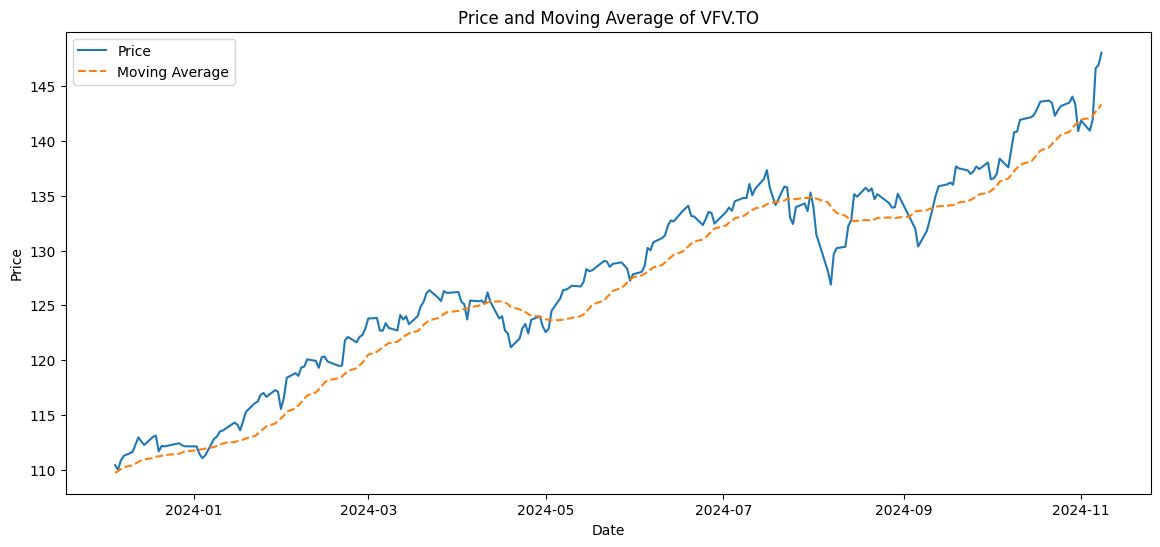

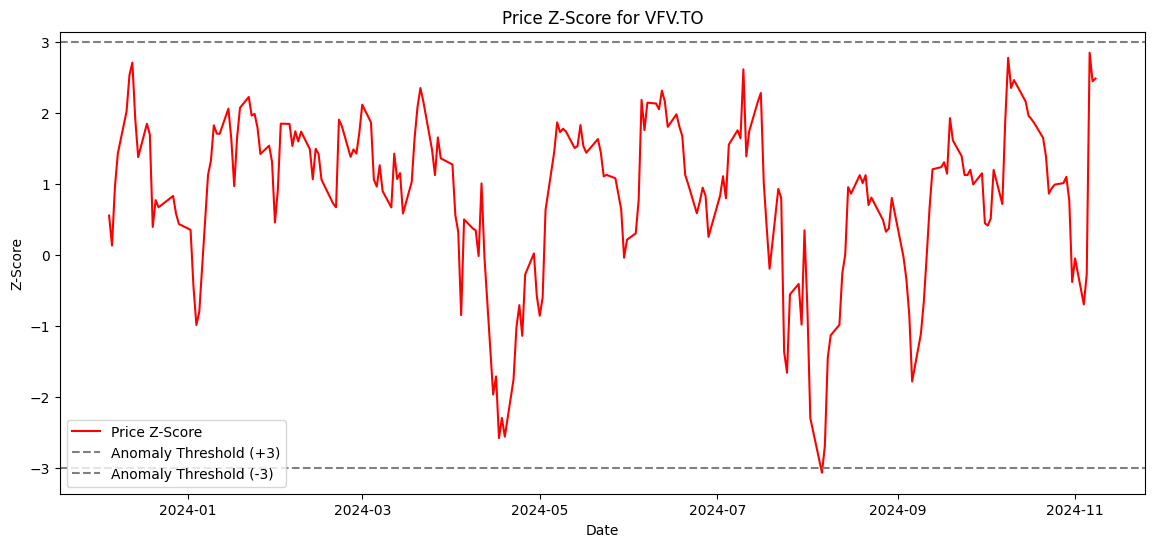

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['price'], label='Price')
plt.plot(data['Date'], data['price_moving_avg'], linestyle='--', label='Moving Average')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Price and Moving Average of VFV.TO')
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['price_z_score'], color='red', label='Price Z-Score')
plt.axhline(y=3, color='gray', linestyle='--', label='Anomaly Threshold (+3)')
plt.axhline(y=-3, color='gray', linestyle='--', label='Anomaly Threshold (-3)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.title(f'Price Z-Score for VFV.TO')
plt.show()


In [65]:
from sklearn.ensemble import IsolationForest

features = data[['price', 'volume', 'price_z_score']]

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
data['anomaly_score'] = iso_forest.fit_predict(features)

data['anomaly'] = data['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

print("Number of anomalies detected:", data['anomaly'].sum())

def calculate_risk_score(row):

    risk_score = abs(row['price_z_score']) * 10
    if row['anomaly'] == 1:
        risk_score += 50
    return risk_score

data['risk_score'] = data.apply(calculate_risk_score, axis=1)

high_risk_trades = data[data['risk_score'] > 50]
print("High-risk trades detected:")
print(high_risk_trades[['Date', 'price', 'volume', 'price_z_score', 'risk_score']])


Number of anomalies detected: 3
High-risk trades detected:
                         Date       price  volume  price_z_score  risk_score
166 2024-08-02 00:00:00+00:00  131.470001  905400      -2.296376   72.963759
167 2024-08-06 00:00:00+00:00  128.100006  751500      -3.065976   80.659756
231 2024-11-06 00:00:00+00:00  146.649994  398800       2.853943   78.539428


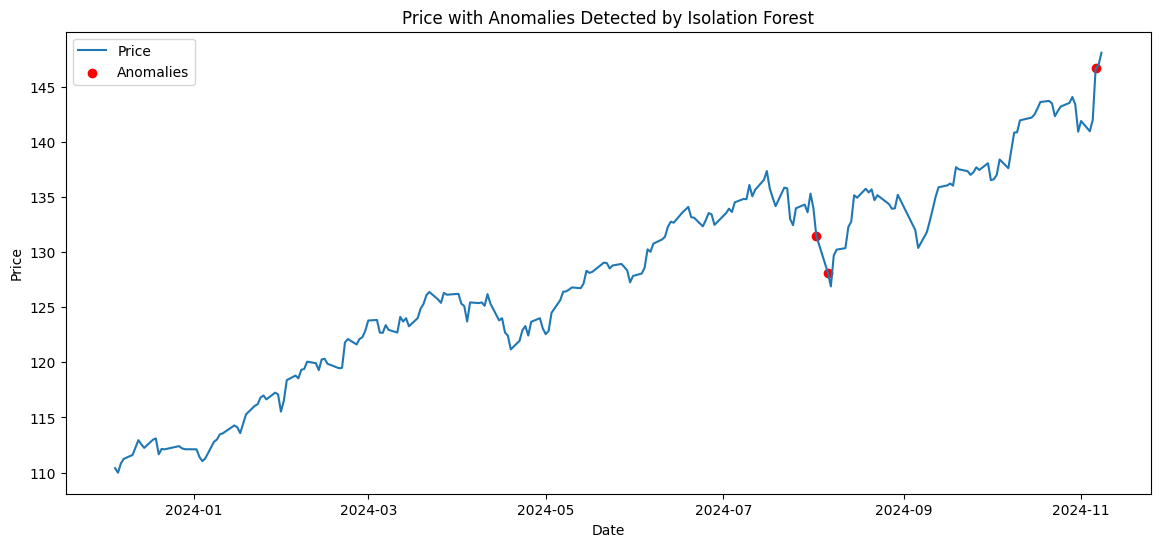

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['price'], label='Price')
plt.scatter(data[data['anomaly'] == 1]['Date'],
            data[data['anomaly'] == 1]['price'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price with Anomalies Detected by Isolation Forest')
plt.legend()
plt.show()


In [67]:

high_risk_trades = data[data['risk_score'] > 50]
print("High-risk trades detected:")
print(high_risk_trades[['Date', 'price', 'volume', 'price_z_score', 'risk_score']])


High-risk trades detected:
                         Date       price  volume  price_z_score  risk_score
166 2024-08-02 00:00:00+00:00  131.470001  905400      -2.296376   72.963759
167 2024-08-06 00:00:00+00:00  128.100006  751500      -3.065976   80.659756
231 2024-11-06 00:00:00+00:00  146.649994  398800       2.853943   78.539428


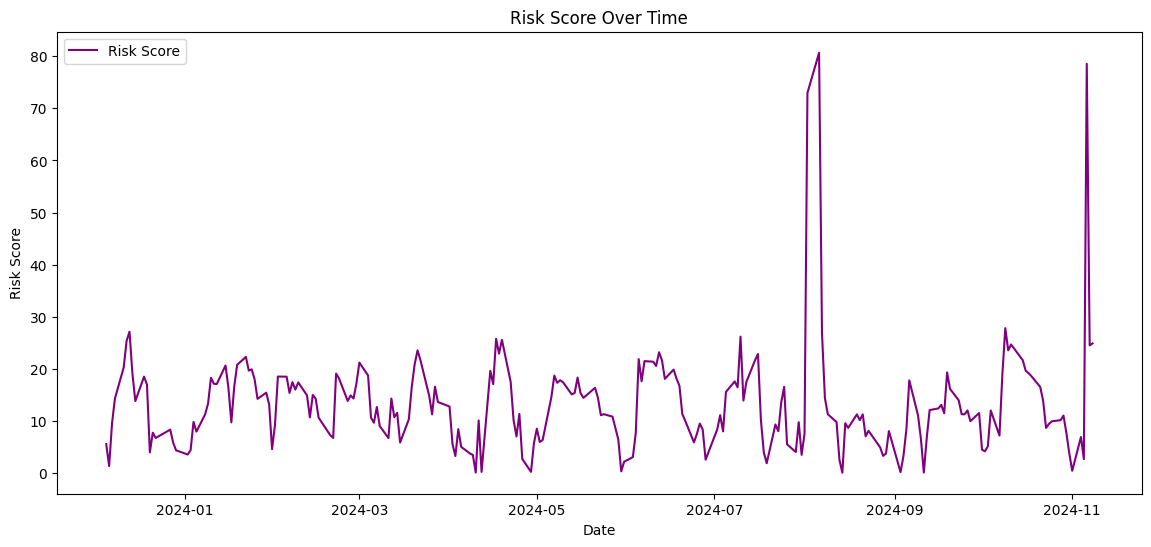

In [71]:

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['risk_score'], label='Risk Score', color='purple')
plt.xlabel('Date')
plt.ylabel('Risk Score')
plt.title('Risk Score Over Time')
plt.legend()
plt.show()


In [72]:
from scipy.stats import kurtosis

data['price_kurtosis'] = data['price'].rolling(window=20).apply(lambda x: kurtosis(x, fisher=False), raw=True)

data['z_score_kurtosis'] = data['price_z_score'].rolling(window=20).apply(lambda x: kurtosis(x, fisher=False), raw=True)

data.dropna(inplace=True)

data[['Date', 'price', 'price_kurtosis', 'z_score_kurtosis']].head()


,Date,price,price_kurtosis,z_score_kurtosis
19,2024-01-04 00:00:00+00:00,111.040001,2.691589,2.565540
20,2024-01-05 00:00:00+00:00,111.290001,3.067646,2.327463
21,2024-01-08 00:00:00+00:00,112.800003,2.079301,2.490298
22,2024-01-09 00:00:00+00:00,113.000000,1.998646,2.478943
23,2024-01-10 00:00:00+00:00,113.470001,2.263192,2.401234


In [73]:

def calculate_risk_score(row):

    risk_score = abs(row['price_z_score']) * 10
    if row['anomaly'] == 1:
        risk_score += 50
    if row['price_kurtosis'] > 3:
        risk_score += (row['price_kurtosis'] - 3) * 10
    return risk_score

data['risk_score'] = data.apply(calculate_risk_score, axis=1)

high_risk_trades = data[data['risk_score'] > 50]
print("High-risk trades detected:")
print(high_risk_trades[['Date', 'price', 'volume', 'price_z_score', 'price_kurtosis', 'risk_score']])


High-risk trades detected:
                         Date       price  volume  price_z_score  \
166 2024-08-02 00:00:00+00:00  131.470001  905400      -2.296376   
167 2024-08-06 00:00:00+00:00  128.100006  751500      -3.065976   
231 2024-11-06 00:00:00+00:00  146.649994  398800       2.853943   

     price_kurtosis  risk_score  
166        2.950014   72.963759  
167        5.551170  106.171460  
231        4.407669   92.616117  


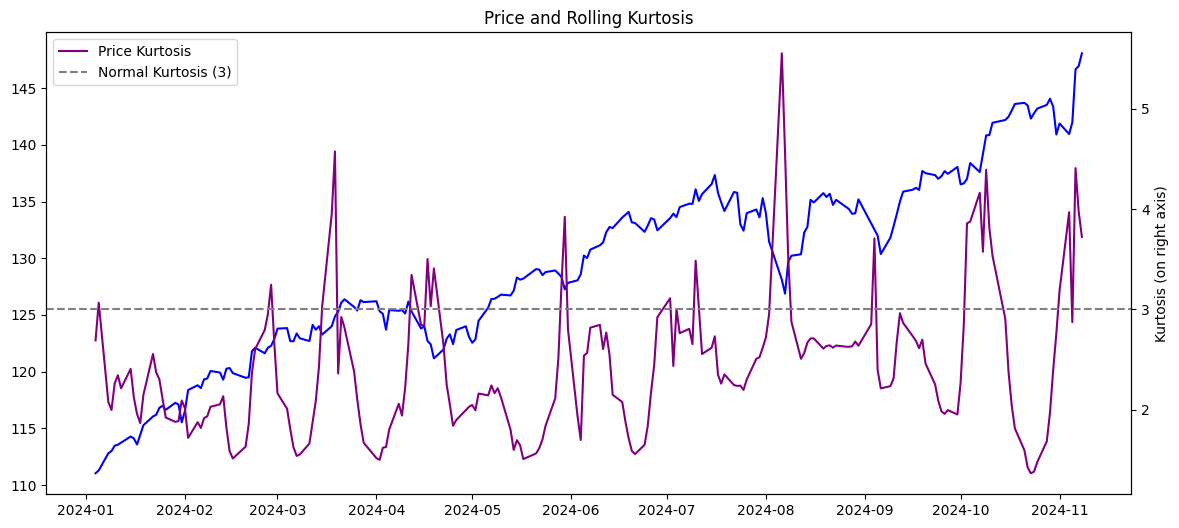

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(data['Date'], data['price'], label='Price', color='blue')

plt.twinx()
plt.plot(data['Date'], data['price_kurtosis'], label='Price Kurtosis', color='purple')
plt.axhline(y=3, color='gray', linestyle='--', label='Normal Kurtosis (3)')

plt.xlabel('Date')
plt.title('Price and Rolling Kurtosis')
plt.legend(loc='upper left')
plt.ylabel('Price')
plt.ylabel('Kurtosis (on right axis)')
plt.show()


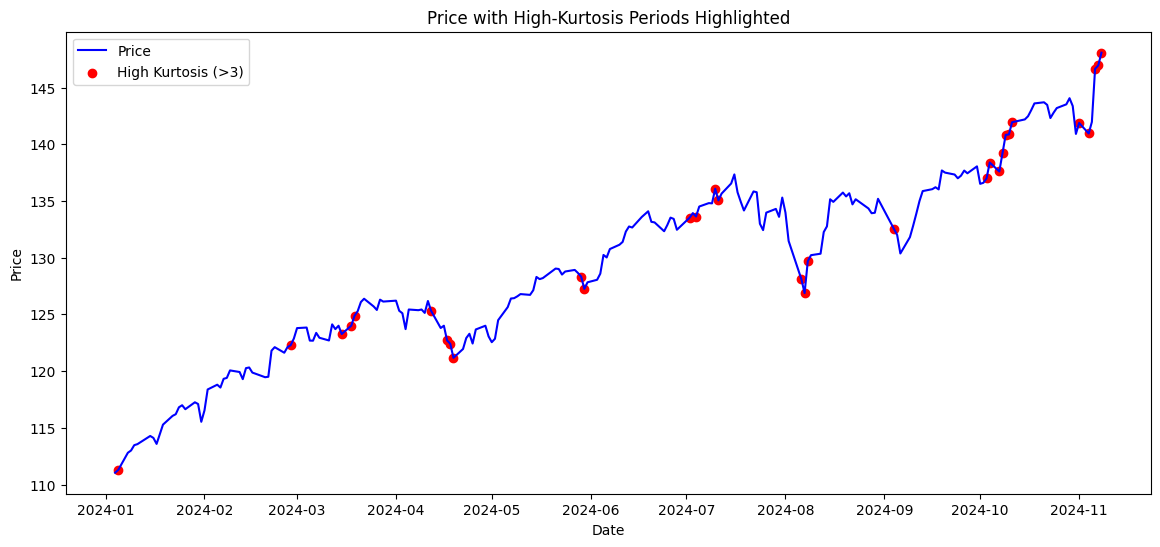

In [76]:

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['price'], label='Price', color='blue')

high_kurtosis = data[data['price_kurtosis'] > 3]
plt.scatter(high_kurtosis['Date'], high_kurtosis['price'], color='red', label='High Kurtosis (>3)')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price with High-Kurtosis Periods Highlighted')
plt.legend()
plt.show()


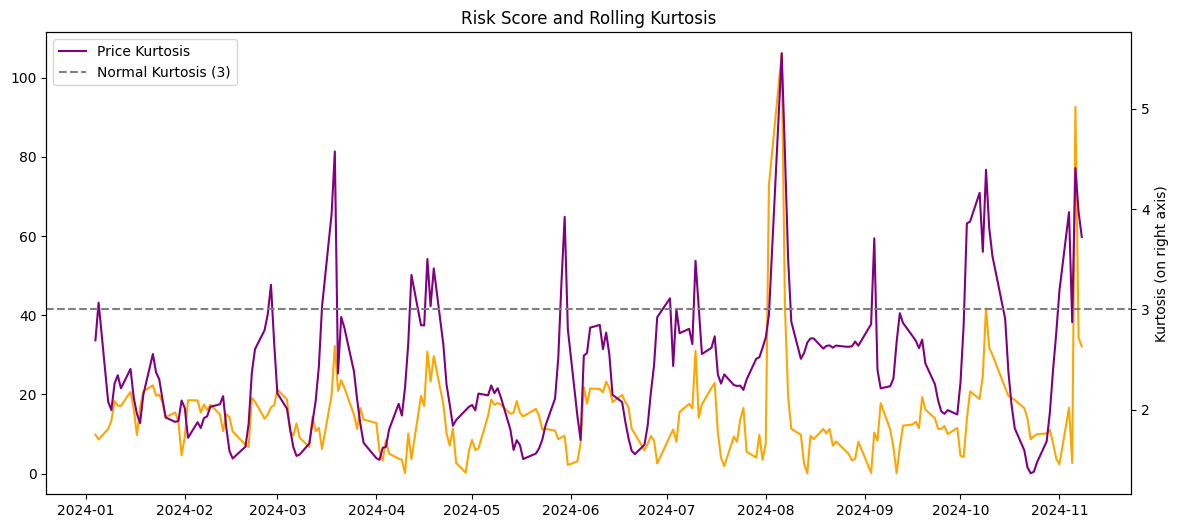

In [77]:

plt.figure(figsize=(14, 6))

plt.plot(data['Date'], data['risk_score'], label='Risk Score', color='orange')

plt.twinx()
plt.plot(data['Date'], data['price_kurtosis'], label='Price Kurtosis', color='purple')
plt.axhline(y=3, color='gray', linestyle='--', label='Normal Kurtosis (3)')

plt.xlabel('Date')
plt.title('Risk Score and Rolling Kurtosis')
plt.legend(loc='upper left')
plt.ylabel('Risk Score')
plt.ylabel('Kurtosis (on right axis)')
plt.show()


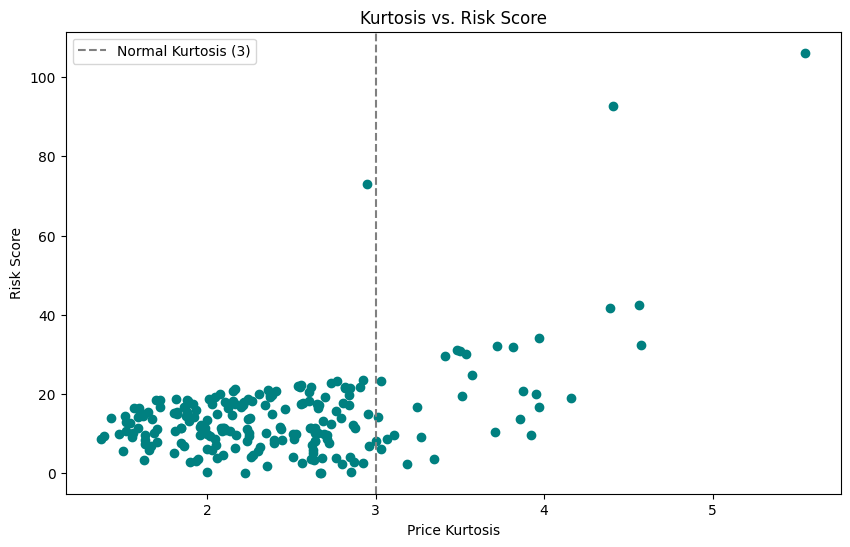

In [78]:

plt.figure(figsize=(10, 6))
plt.scatter(data['price_kurtosis'], data['risk_score'], color='teal')
plt.axvline(x=3, color='gray', linestyle='--', label='Normal Kurtosis (3)')
plt.xlabel('Price Kurtosis')
plt.ylabel('Risk Score')
plt.title('Kurtosis vs. Risk Score')
plt.legend()
plt.show()


In [50]:
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 48.2 MB/s eta 0:00:00


In [79]:
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

data['returns'] = data['price'].pct_change().dropna()

garch_model = arch_model(data['returns'].dropna(), vol='Garch', p=1, q=1)
garch_fitted = garch_model.fit(disp="off")

data['conditional_volatility'] = garch_fitted.conditional_volatility


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.366e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


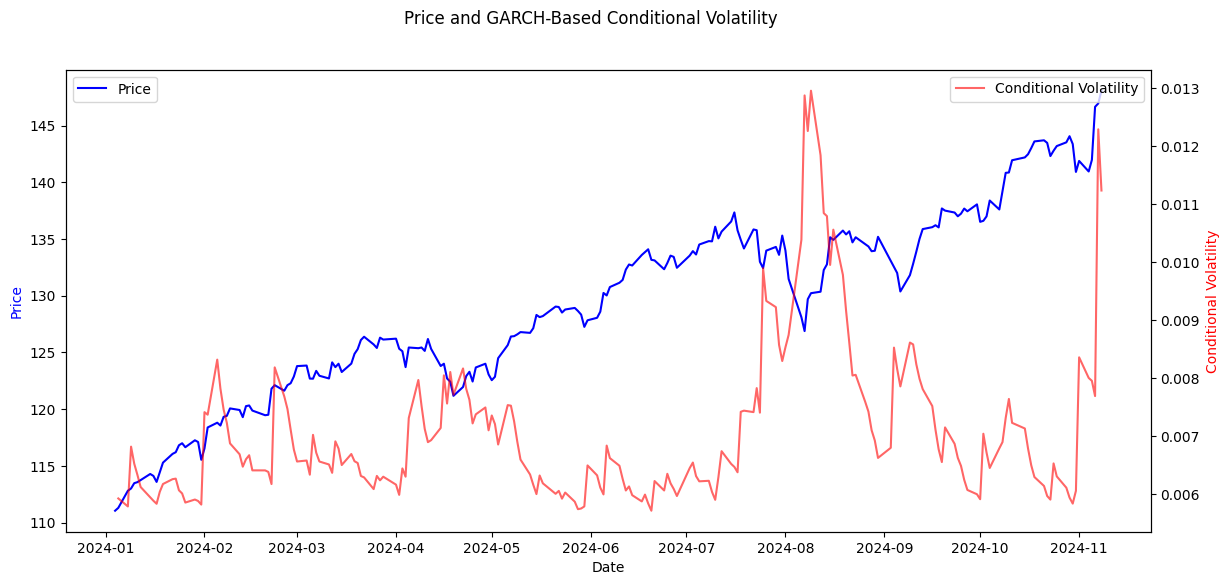

In [80]:

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(data['Date'], data['price'], label='Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='blue')

ax2 = ax1.twinx()
ax2.plot(data['Date'], data['conditional_volatility'], label='Conditional Volatility', color='red', alpha=0.6)
ax2.set_ylabel('Conditional Volatility', color='red')

fig.suptitle('Price and GARCH-Based Conditional Volatility')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


In [81]:
def calculate_risk_score(row):

    risk_score = abs(row['price_z_score']) * 10
    if row['anomaly'] == 1:
        risk_score += 50

    risk_score += row['conditional_volatility'] * 100
    return risk_score


data['risk_score'] = data.apply(calculate_risk_score, axis=1)

high_risk_trades = data[data['risk_score'] > 50]
print("High-risk trades detected:")
print(high_risk_trades[['Date', 'price', 'volume', 'price_z_score', 'conditional_volatility', 'risk_score']])


High-risk trades detected:
                         Date       price  volume  price_z_score  \
166 2024-08-02 00:00:00+00:00  131.470001  905400      -2.296376   
167 2024-08-06 00:00:00+00:00  128.100006  751500      -3.065976   
231 2024-11-06 00:00:00+00:00  146.649994  398800       2.853943   

     conditional_volatility  risk_score  
166                0.008746   73.838403  
167                0.010387   81.698469  
231                0.007692   79.308608  


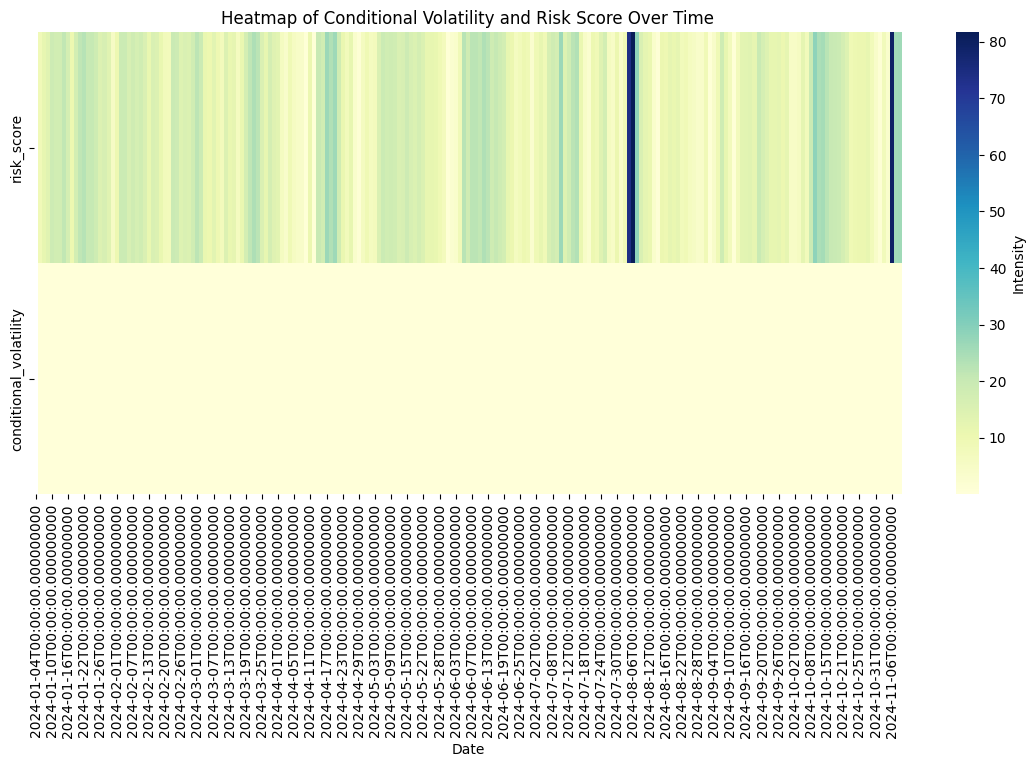

In [82]:
import seaborn as sns

heatmap_data = data[['Date', 'risk_score', 'conditional_volatility']].set_index('Date')

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data.T, cmap="YlGnBu", cbar_kws={'label': 'Intensity'}, annot=False)
plt.title('Heatmap of Conditional Volatility and Risk Score Over Time')
plt.xlabel('Date')
plt.show()


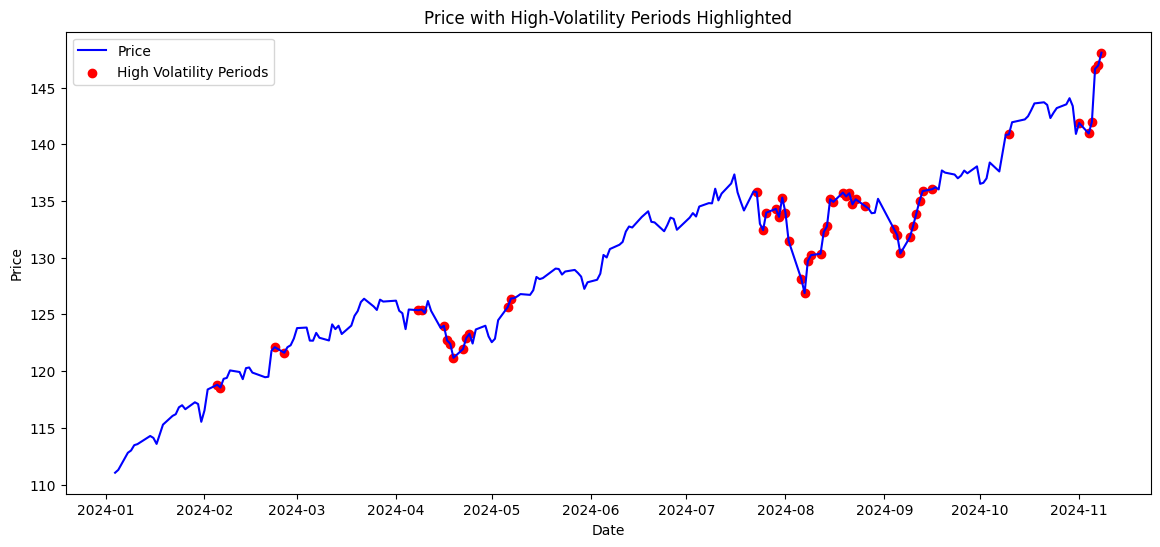

In [83]:

high_volatility_threshold = data['conditional_volatility'].quantile(0.75)

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['price'], label='Price', color='blue')

high_volatility = data[data['conditional_volatility'] > high_volatility_threshold]
plt.scatter(high_volatility['Date'], high_volatility['price'], color='red', label='High Volatility Periods')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price with High-Volatility Periods Highlighted')
plt.legend()
plt.show()
